# Imports

In [1]:
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [19]:
from tensorflow.data import AUTOTUNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Deep Autoencoder - CelebA

Visualizar o encoding e decoding de rostos humanos, usando um autoencoder profundo e o dataset CelebA (+200.000 amostras) \
Dataset disponível em: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

## Carregamento do dataset e divisão em treino, teste e validação

In [4]:
# Carregamento do dataset via arquivo zip
caminho_arquivo = '/content/drive/MyDrive/projetos/celebA_autoencoders/CelebA_images.zip'
pasta_destino = '/content/CelebA_dataset'

with zipfile.ZipFile(caminho_arquivo, 'r') as z:
  z.extractall(pasta_destino)

In [20]:
# Divisão em base de treino e validação
full_train = image_dataset_from_directory(
    directory='/content/CelebA_dataset',
    label_mode=None,
    validation_split=0.1,
    subset='training',
    batch_size=32,
    image_size=(36,44),
    shuffle=False
)

val_ds = image_dataset_from_directory(
    directory='/content/CelebA_dataset',
    label_mode=None,
    validation_split=0.1,
    subset='validation',
    batch_size=32,
    image_size=(36,44),
    shuffle=False
)

# Pegando parte do treino como teste
test_size = 0.2
test_ds = full_train.take(int(len(full_train) * test_size))
train_ds = full_train.skip(int(len(full_train) * test_size))

# Treino -> 72%
# Teste  -> 18%
# Val    -> 10%

Found 202599 files.
Using 182340 files for training.
Found 202599 files.
Using 20259 files for validation.


In [21]:
print('- ' * 10)
print(f'{int(len(train_ds) * 32)} - {int(len(train_ds) * 32) / 202599:.2%}')
print(f'{int(len(test_ds) * 32)} - {int(len(test_ds) * 32) / 202599:.2%}')
print(f'{int(len(val_ds) * 32)} - {int(len(val_ds) * 32) / 202599:.2%}')

- - - - - - - - - - 
145920 - 72.02%
36448 - 17.99%
20288 - 10.01%


## Normalização dos valores

In [22]:
# Normaliza os valores dos pixels na escala [0,1]
def normaliza_ds(image):
  image = tf.cast(image, tf.float32) / 255
  return image

train_ds = train_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().prefetch(AUTOTUNE)

test_ds = test_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

val_ds = val_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

## Valores para 1D array

In [23]:
train_ds = train_ds.map(lambda x: tf.reshape(x, (tf.shape(x)[0], -1)))
test_ds = test_ds.map(lambda x: tf.reshape(x, (tf.shape(x)[0], -1)))
val_ds = val_ds.map(lambda x: tf.reshape(x, (tf.shape(x)[0], -1)))

In [24]:
print(next(iter(train_ds.take(1))).shape)
print(next(iter(test_ds.take(1))).shape)
print(next(iter(val_ds.take(1))).shape)

(32, 4752)
(32, 4752)
(32, 4752)


In [25]:
train_ds = train_ds.map(lambda x: (x, x))
test_ds = test_ds.map(lambda x: (x, x))
val_ds = val_ds.map(lambda x: (x, x))

## Definição do Deep Autoencoder

In [29]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=.5,
)

In [28]:
deep_autoencoder = Sequential([
  InputLayer(shape=(4752,)),
  Dense(1024, activation='leaky_relu'),
  Dense(512, activation='leaky_relu'),
  Dense(256, activation='leaky_relu'),
  Dense(512, activation='leaky_relu'),
  Dense(1024, activation='leaky_relu'),
  Dense(4752, activation='sigmoid')
])

In [30]:
deep_autoencoder.compile(optimizer='adam', loss='mse')

In [31]:
deep_autoencoder.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 1024)           │     4,867,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4752)           │     4,870,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,050,896 (42.16 MB)

 Trainable params: 11,050,896 (42.16 MB)

 Non-trainable params: 0 (0.00 B)

## Treinamento do autoencoder

In [32]:
history = deep_autoencoder.fit(train_ds, epochs=40, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])

Epoch 1/40
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 0.0268 - val_loss: 0.0159 - learning_rate: 0.0010
Epoch 2/40
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.0149 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 3/40
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0132 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 4/40
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0123 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 5/40
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0116 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 6/40
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0110 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 7/40
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0106 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 8/40
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0103 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 9/40
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0099 - val_loss: 0.1757 - lear

## Salvamento e carregamento do AE

In [34]:
deep_autoencoder.save('deep_autoencoder.keras')

In [35]:
deep_autoencoder = tf.keras.models.load_model('/content/drive/MyDrive/projetos/celebA_autoencoders/deep_autoencoder/deep_autoencoder.keras')

## Definição do encoder

In [92]:
encoder = Sequential(deep_autoencoder.layers[:3])

## Gráficos e visualização

In [108]:
fixed_samples = np.load('/content/drive/MyDrive/projetos/celebA_autoencoders/fixed_samples.npy')

fixed_samples = tf.reshape(fixed_samples, (-1, 178, 218, 3)) # (10, 178, 218, 3)
fixed_samples = tf.image.resize(fixed_samples, (36, 44)) # (10, 36, 44, 3)
fixed_samples = tf.reshape(fixed_samples, (5, 2, -1)).numpy() # (5, 2, 7452)

In [109]:
fixed_samples.shape

(5, 2, 4752)

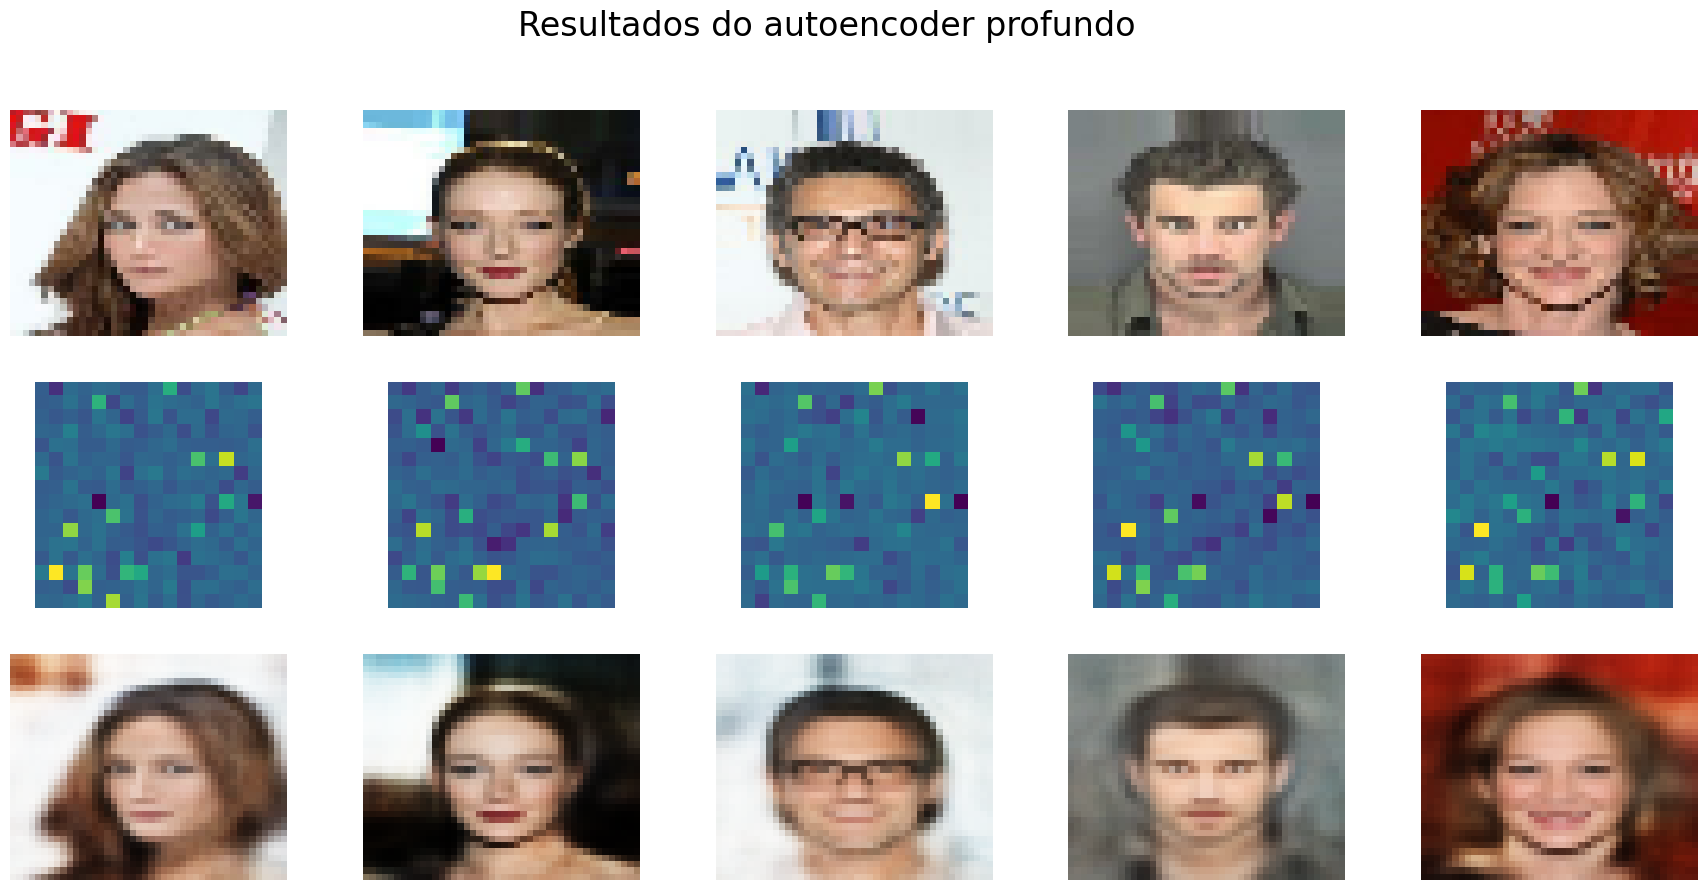

In [110]:
samples = fixed_samples

plt.figure(figsize=(22, 10))
for i, (im, _) in enumerate(samples):
  im = tf.expand_dims(im, axis=0)
  latent = encoder.predict(im, verbose=False)
  decoded = deep_autoencoder.predict(im, verbose=False)
  decoded = tf.clip_by_value(decoded, 0, 1)

  plt.suptitle('Resultados do autoencoder profundo', fontsize=24)

  plt.subplot(3, 5, i+1)
  plt.imshow(tf.reshape(im, (36, 44, 3)))
  plt.axis('off')

  plt.subplot(3, 5, i+6)
  plt.imshow(tf.reshape(latent, (16, 16)), cmap='viridis')
  plt.axis('off')

  plt.subplot(3, 5, i+11)
  plt.imshow(tf.reshape(decoded, (36, 44, 3)))
  plt.axis('off')

In [111]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

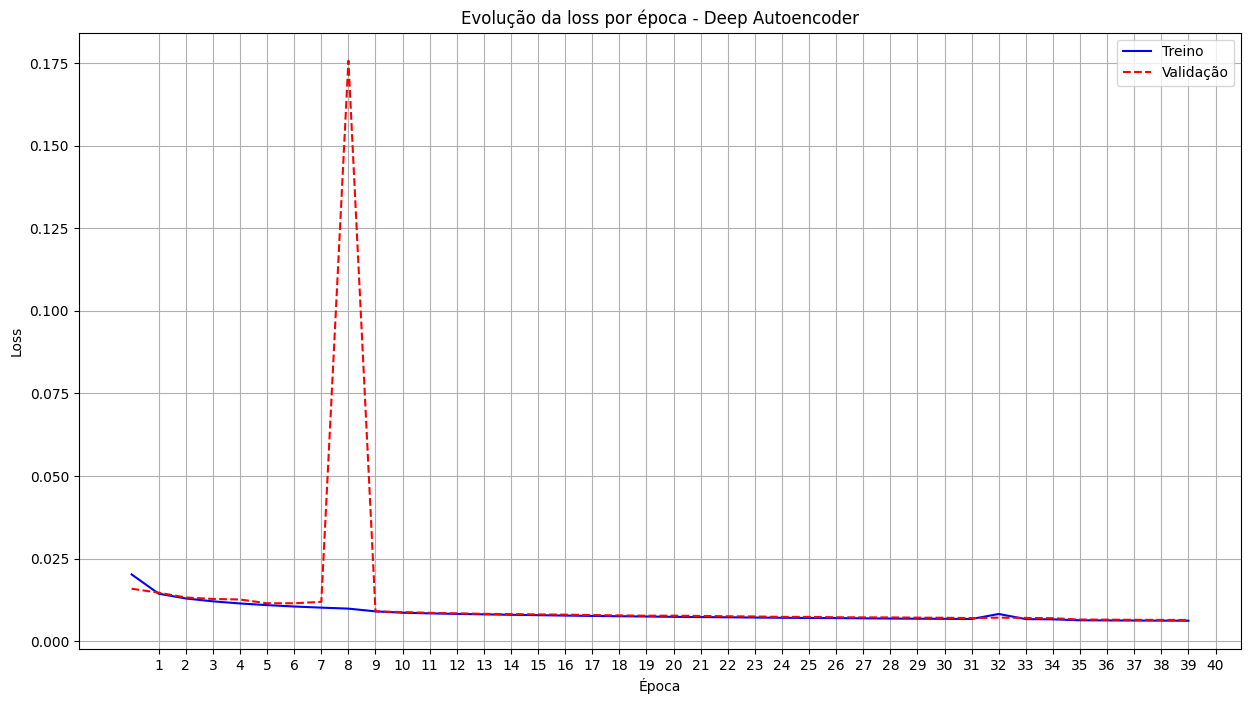

In [113]:
plt.figure(figsize=(15, 8))
plt.plot(loss, 'b-', label='Treino')
plt.plot(val_loss, 'r--', label='Validação')
plt.xticks(epochs)
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolução da loss por época - Deep Autoencoder')
plt.legend()
plt.grid(True)
plt.show();